# Práctica 1 - Clasificación de palabras

## Introducción
El problema que se nos plantea en esta práctica es la clasificación, mediante un modelo basado en SVM, de las palabras de un dataset según la lengua a la que pertenecen. En primera instáncia solamente tenemos palabras del catalán y el inglés, pero se pueden añadir más palabras de otros idiomas usando librerías como [Googletrans](https://www.thepythoncode.com/article/translate-text-in-python#:~:text=Googletrans%20is%20a%20free%20and,detect%20languages%20and%20translate%20text.). 

In [2]:
# Misc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean
from matplotlib.colors import ListedColormap
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

# CrossValidation
## K-folding
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

## GridSearch
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#https://scikit-learn.org/stable/modules/model_evaluation.html

# Model
from sklearn.svm import SVC

## Preparación de los datos
En esta primera parte de la práctica vamos a preparar los datos para poder hacer la clasificación. Para ello haremos que cada muestra siga el siguiente formato: $C_1$ | $C_2$ | $C_3$ | .. | $C_n$ | $y$  (siendo $C$ una característica y $y$ el target).

Se va a codificar $y$ con los valores "0" para representar la clase _anglés_ y "1" para la clase _català_. Si añadieramos más idiomas, simplemente seguiríamos con este formato, siendo por ejemplo _francés_ "2", _alemán_ "3", etc. Esto se conoce como [Label Encoding](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd). Este tipo de codificación de variables categóricas nos viene como anillo al dedo, ya que no puede dar lugar a la confusión de que los números representan una jerarquía, debido a que estamos tratando con lenguas modernas (la jerarquía podría indicar lo cerca que está esa lengua de su lengua madre, el latín por ejemplo). 

La otra opción sería llevar a cabo Hot Encoding, lo que supondría crear más variables $y$ con los valores 1 y 0 para indicar si pertenece una palabra a un idioma. Esta aproximación nos podría acabar incrementando muchísimo la dimensionalidad del problema.

In [3]:
#Auxiliar function that reformats df to one that is more fitting to Classification Problems
def reformat(dataFrame):
    dataFrame['y']=dataFrame.columns[0]
    
    dataFrame.rename(columns={dataFrame.columns[0]: 'word'}, inplace=True)
    return dataFrame

#RawData, it has been a little bit formatted before reading the csv, to facilitate the process.
raw=pd.read_csv("data/data.csv")
#Split df
catala, angles= raw.filter(['catala'], axis=1), raw.filter(['angles'], axis=1)
#Reformating
catala=reformat(catala)
angles=reformat(angles)

#Merging
wordsDF=pd.concat([catala,angles], axis=0)

#Encoding variables
wordsDF['y']=wordsDF['y'].astype('category')
wordsDF['y']=wordsDF['y'].cat.codes
#Shuffle the rows
wordsDF = wordsDF.sample(frac=1).reset_index(drop=True)



## Soluciones consideradas

### Caracterísiticas
Las características que hemos pensado que pueden ser útiles para la clasificación de las palabras son:
- Cantidad de caracteres (Númerica)
- Proporción de consonantes por vocal (consonantes / vocales) (Numérica)
- Contiene patrones o normas ortográficas de una lengua de las que vamos a clasificar?
    + Doble uso de vocal consecutivamente como es el caso del inglés (Categórica)
    + Acentos en caso de catalán (Categórica)
    + Contiene combinaciones de consonantes (consonant clusters) propias del inglés? (Categórica)

Referencias
- <[Consonant_Clusters](https://www.aprendeinglessila.com/2013/09/consonantes-ingles-clusters)>
- <[Frecuencia_De_Letras_Usadas_En_Catalan](https://es.sttmedia.com/frecuencias-de-letras-catalan)>
- <[Frecuencia_De_Letras_Usadas_En_Catalan](https://www3.nd.edu/~busiforc/handouts/cryptography/letterfrequencies.html)>

Para añadir las columnas que representen estas características, hemos aplicado las siguientes funciones a las palabras.

In [4]:
#ratio de consonantes y vocales
def ratio (word):
    vocals=0
    for c in word:
        if isVocal(c):
            vocals+=1
    return round(vocals/len(word), 4)

#isVocal?
def isVocal(c):
    if(c=='a' or c=='e' or c=='i' or c=='o' or c=='u'):
        return True
    return 
#gotAccent?
def gotAccent(word):
    #List containing all possible accentuated chars from Catalan
    ocurrences=[ord('à'),ord('è'),ord('é'),ord('í'),ord('ò'),ord('ó'),ord('ú')]
    for c in word:
        if ord(c) in ocurrences:
            return 1
    return 0
#DoubleVocal?
def doubleVocal(word):
    ocurrences=["aa","ee","ii","oo","uu"]
    for oc in ocurrences:
        if word.find(oc)!=-1:
            return 1
    return 0
#Does it have an english consonant cluster?
def enCC(word):
    ocurrences=["sch","spl","shr","squ","thr","spr","scr","sph","th","tw","ch","sh","sw","sk","sm","tt","pp","bb","dd","ff","gg","vv","ww","zz"]
    for oc in ocurrences:
        if word.find(oc)!=-1:
            return 1
    return 0
#Does it have a catalan
def gotCedilla(word):
    ocurrences=["ç"]
    for oc in ocurrences:
        if word.find(oc)!=-1:
            return 1
    return 0

#Features Adding
wordsDF['ratio']=wordsDF['word'].apply(ratio)
wordsDF['cantidadLetras']=wordsDF['word'].apply(len)
wordsDF['gotAccent']=wordsDF['word'].apply(gotAccent)
wordsDF['gotCedilla']=wordsDF['word'].apply(gotCedilla)
wordsDF['doubleVocal']=wordsDF['word'].apply(doubleVocal)
wordsDF['enCC']=wordsDF['word'].apply(enCC)
#Reorganize DF
wordsDF=wordsDF[['word','ratio','cantidadLetras','gotAccent','gotCedilla','doubleVocal','enCC','y']]
#Write DF to csv
wordsDF.to_csv('data/definitiveData.csv', index=False)
#Checking
print(wordsDF)

          word   ratio  cantidadLetras  gotAccent  gotCedilla  doubleVocal  \
0        wrote  0.4000               5          0           0            0   
1        només  0.2000               5          1           0            0   
2     mantenir  0.3750               8          0           0            0   
3       though  0.3333               6          0           0            0   
4      conjunt  0.2857               7          0           0            0   
...        ...     ...             ...        ...         ...          ...   
1971  mantenir  0.3750               8          0           0            0   
1972       dir  0.3333               3          0           0            0   
1973    plural  0.3333               6          0           0            0   
1974   paraula  0.5714               7          0           0            0   
1975    sister  0.3333               6          0           0            0   

      enCC  y  
0        0  0  
1        0  1  
2        0  1  

### Métricas
Dado que el problema que tenemos delante es uno de clasificación, las métricas que nos serán más útiles son:
- __Accuracy__ (Exactitud): Métrica que mide la proporción de predicciones correctas. Esto se hace haciendo la división entre las predicciones correctas entre el total de predicciones realizadas. Esta métrica suele ser útil en conjuntos de datos donde las clases están distribuidas de manera equilibrada, como en nuestro caso. 
- __Precision__ (Precisión): Métrica que mide la proporción de verdaderos positivos entre todos los positivos ( _TP_ y _FP_ ) detectados por el modelo. Normalmente se utiliza cuando se quiere evitar la detección de falsos positivos, como podría ser en testeos médicos. En esta práctica no se nos especifíca la importancia que habría en evitar falsos positivos, pero aún así usaremos esta métrica con fines de estudio.
- __Recall__ (Sensibilidad): Métrica que mide la proporción de verdaderos positivos detectados entre los positivos que realmente existen ( _TP_ y _FN_ ). Esta métrica se utiliza cuando es importante evitar falsos negativos, pero al igual que la métrica anterior, lo usaremos por fines académicos. 

Por último indicar que también se usará una matriz de confusión para mostrar los resultados de una manera más gráfica. 

### Separación del conjunto de datos en entrenamiento y test
Vamos a escoger dos tercios para el conjunto de entrenamiento y el resto para el test.
 Puntualizar que se han normalizado los datos para un mejor rendimiento del modelo. Solo se han escalado los datos numéricos, ya que sería erróneo escalar todo el dataset, con los categóricos, ya que podría dar lugar a dar menos importancia a estos últimos. 

 En esta sección se preparan los conjuntos de datos para realizar los experimentos 1, 2 y 3.

In [20]:
#First we must separate dataframe into X and y format
X=wordsDF.iloc[:,1:7]
y=wordsDF.iloc[:,7]

#Auxiliar portion of observations set, with only numerical values
X_aux=wordsDF.iloc[:,1:3]


#For better perfomance, we scale the data using a standard scaler
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_aux)
standardData_Only_Num = scaler.transform(X_aux)

#Standarized DF
standardData=X
#Substitute standarized values in correspondent columns
standardData['ratio']=standardData_Only_Num[:,0]
standardData['cantidadLetras']=standardData_Only_Num[:,1]

#Only Numerical values dataframe
X_cat = standardData.iloc[:,2:]
#Then we separate the data frame in training and test (will be used in chosen model)
#Experiment 1 train and test
X_train, X_test, y_train, y_test = train_test_split(standardData, y, test_size=0.33, random_state=11)

#Experiment 2 train and test
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(standardData_Only_Num,y, test_size=0.33, random_state=22)

#Experiment 3 train and test
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat,y,test_size=0.33, random_state=33)

<class 'pandas.core.series.Series'>


## Experimentos
En este problema creemos que el mejor modelo para clasificar las palabras va a ser una SVM con un kernel gaussiano (__rbf__) ya que tenemos un número de características bastante bajo en comparación al número de muestras. Se han hecho pruebas con un kernel líneal, y si bien los resultados se acercan, el kernel gaussiano ha dado mejores resultados de media.

Los híperparámetros que deberemos de configurar en el modelo del SVM son:
- _C_: El parámetro __C__ en una SVM es un hiperparámetro que controla __la flexibilidad__ del modelo. Se utiliza para controlar el trade-off entre la complejidad del modelo y la cantidad de errores de clasificación que se permiten. Si C es un valor alto, el modelo se vuelve menos flexible y puede tender al overfitting. Si C es un valor bajo, el modelo es más flexible y permite más errores de clasificación. 

- _max\_iter_: __Número máximo de iteraciones__ que se llevará acabo en el entrenamiento del modelo, para encontrar una solución óptima. Si el parámetro es muy pequeño puede que no encuentre una solución óptima y tenga un rendimiento bajo. Por lo contrario si ponemos un valor muy alto podría alargar el tiempo de entrenamiento innecesariamente, ya que una solución óptima se podría encontrar con menos iteraciones.

- _gamma_: Controla el __ancho del kernel__. Cuanto mayor es su valor, menor es el ancho del kernel y viceversa. Si el kernel es muy ancho el modelo se vuelve más suave y no es tan sensible a los detalles de las muestras. 

El resto de híperparámetros no son tan necesarios ya que no se ajustan al problema. (Explicar algún que otro parámetro y decir por qué no es útil)
### Primer experimento
En el primer experimento, entrenaremos a un modelo basado en SVM con todo el conjunto de características diseñado anteriormente. Los resultados que saquemos de este primer experimento, los usaremos como comparación para los siguientes y a raíz de estos sacaremos unas conclusiones.


In [41]:
#Model
SVM_rbf = SVC(kernel='rbf')

### Nested Cross-Validation
Para elegir los mejores valores para los híperparámetros y a su vez elegir el modelo que mejor generaliza debemos de hacer uso de la técnica __Nested Cross-validation__. Esta técnica consiste en dos bucles, uno exterior y otro interior:
- En el interior se aplica __GridSearch__, donde se extrae la configuración de híperparámetros que mejores resultados da.
- En el exterior se hace un reentrenamiento con estos híperparámetros y se prueba el modelo con el conjunto de test correspondiente.

Al final del proceso tendremos K modelos, con el score (_accuracy_ normalmente) correspondiente a cada uno.

Referencias:<br>
- <https://ploomber.io/blog/nested-cv/>
- En este artículo se demuestra que hacer solo cross-validation puede resultar en un error de generalización optimista (debido a overfitting) 
<https://jmlr.csail.mit.edu/papers/volume11/cawley10a/cawley10a.pdf>


In [42]:
#Hyper Grid
hyper_grid = {"C":[0.1,1,10],"max_iter":[100,1000,10000],"gamma":[.01,.1,1]}
#Inner and Outer crossvalidation, following steps from :
#https://www.analyticsvidhya.com/blog/2021/03/a-step-by-step-guide-to-nested-cross-validation/
# and
# https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_nested.html

inner_cv=StratifiedKFold(n_splits=3, shuffle=True)
outer_cv=StratifiedKFold(n_splits=5, shuffle=True)
#GridSearch definition
search=GridSearchCV(estimator=SVM_rbf,cv=inner_cv,param_grid=hyper_grid,scoring="accuracy",n_jobs=-1)

#Test score after nesting
test_score=cross_val_score(search,X_train,y_train,cv=outer_cv,n_jobs=-1)
#search.fit(X_train,y_train)
#Printing results of Nested Cross-Validation
print(f"Mean score of Nested cross-validation:"f"{test_score.mean():.3f}+-{test_score.std():.3f}")
#print(f"The best estimator is:"f"{search.best_estimator_}")

Mean score of Nested cross-validation:0.671+-0.006


In [43]:
#CrossValidation
inner_cv_man=StratifiedKFold(n_splits=3, shuffle=True)
outer_cv_man=StratifiedKFold(n_splits=5, shuffle=True)
best_models = []
best_scores = []
#GridSearch definition
search=GridSearchCV(estimator=SVM_rbf,cv=inner_cv,param_grid=hyper_grid,scoring="accuracy",n_jobs=-1)
aux_X=X_train.to_numpy()
aux_y=y_train.to_numpy()
for train, test in outer_cv_man.split(aux_X,aux_y):
    
    X_train_cv, y_train_cv = aux_X[train], aux_y[train]
    X_test_cv, y_test_cv = aux_X[test], aux_y[test]
    modelo = search.fit(X_train_cv, y_train_cv)
    best_models.append(modelo.best_estimator_)
    best_scores.append(modelo.best_score_)


c:\Users\pablo\miniconda3\envs\aprenentatge_automatic_2223\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [44]:
#Escogemos el mejor modelo obtenido del Nested Cross-validation
modeloExperimento_1 = best_models[best_scores.index(max(best_scores))]
print(modeloExperimento_1)

SVC(C=1, gamma=1, max_iter=1000)


### Prueba del modelo con los parámetros encontrados

Una vez hemos encontrado los mejores híperparámetros para el SVM con Kernel Gaussiano, procedemos a entrenarlo y a realizar la predicción.

Accuracy: 0.669
Precision: 0.624
Recall: 0.699


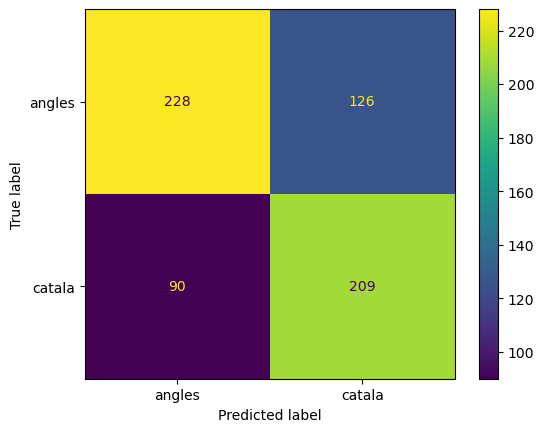

In [63]:
#Re-train Model with Train set
modeloExperimento_1.fit(X_train,y_train)

#Predict with X_test
y_predicted=modeloExperimento_1.predict(X_test)

##Accuracy
print(f"Accuracy: {accuracy_score(y_test,y_predicted):.3f}")

##Precision
print(f"Precision: {precision_score(y_test,y_predicted):.3f}")
#Recall 
print(f"Recall: {recall_score(y_test,y_predicted):.3f}")
#Confussion Matrix
cm=confusion_matrix(y_test,y_predicted, labels=modeloExperimento_1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["angles","catala"])
disp.plot()
plt.show()

### Conclusiones primer experimento
En este primer experimento, el modelo ha conseguido una __accuracy__ de un 0.669, casi el mismo valor que el inferido del __nested cross-validation__ (0.671). Es un valor de precisión decente, pero podría llegar a aumentarse, por ejemplo, añadiendo características que indiquen el origen de la raíz de una palabra (origen latín o gérmano).<br>
En cuanto a las otras métricas:
- _Precision_: El modelo ha predecido bien un 62.4% del total de muestras que han sido clasificadas como pertenecientes a la clase positiva (catalán en este caso ya que su valor categórico es el 1). 
- _Recall_: En cuanto a la sensibilidad, el modelo ha predecido bien el 69.9% de las muestras la clase positiva, del total real de muestras de la clase positiva.

En cuanto a la matriz de confusión, puntualizar que la función _ConfusionMatrixDisplay_ muestra la matriz en un orden distinto al que estamos acostumbrados. Para más información: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html